# 퍼널 분석

### 사전 분석 : hits
- 사용자 행동에 대한 상세 정보가 담긴 hits 컬럼값 분석

In [1]:
import os
import ast
import json
import random
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
color = sns.color_palette()

%matplotlib inline

from plotly import tools
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

from sklearn import model_selection, preprocessing, metrics
import lightgbm as lgb

pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 999

from pandas import json_normalize

In [2]:
train_path = 'new_train.csv'
train_df = pd.read_csv(train_path)

/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_35823/521266735.py:2: DtypeWarning:

Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.



In [3]:
train_df.head()

,channelGrouping,customDimensions,date,device,fullVisitorId,geoNetwork,hits,socialEngagementType,totals,trafficSource,visitId,visitNumber,visitStartTime
0,Direct,"[{'index': '4', 'value': 'North America'}]",20160801,"{""browser"": ""Safari"", ""browserVersion"": ""not a...",6849420071276447389,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""33"", ""pageviews"": ""13...","{""campaign"": ""(not set)"", ""source"": ""(direct)""...",1470074045,1,1470074045
1,Referral,"[{'index': '4', 'value': 'North America'}]",20160801,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",1231590494443171080,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '8', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""31"", ""pageviews"": ""23...","{""referralPath"": ""/"", ""campaign"": ""(not set)"",...",1470067091,2,1470067091
2,Direct,"[{'index': '4', 'value': 'North America'}]",20160801,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",6751290259214798595,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '6', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""31"", ""pageviews"": ""21...","{""campaign"": ""(not set)"", ""source"": ""(direct)""...",1470056945,1,1470056945
3,Referral,"[{'index': '4', 'value': 'North America'}]",20160801,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",3213840074316400693,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '6', ...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""32"", ""pageviews"": ""24...","{""referralPath"": ""/"", ""campaign"": ""(not set)"",...",1470057237,2,1470057237
4,Referral,"[{'index': '4', 'value': 'North America'}]",20160801,"{""browser"": ""Chrome"", ""browserVersion"": ""not a...",2987126973357946088,"{""continent"": ""Americas"", ""subContinent"": ""Nor...","[{'hitNumber': '1', 'time': '0', 'hour': '21',...",Not Socially Engaged,"{""visits"": ""1"", ""hits"": ""32"", ""pageviews"": ""24...","{""referralPath"": ""/"", ""campaign"": ""(not set)"",...",1470112710,1,1470112710


## 사용자 행동 분석을 위한 컬럼 전처리

In [39]:
def load_df(csv_path):
    JSON_COLUMNS = ['device', 'geoNetwork', 'totals', 'trafficSource']

    df = pd.read_csv(csv_path,
                     converters={column: json.loads for column in JSON_COLUMNS},
                     dtype={'fullVisitorId': 'str'} # Important!!
                    )

    for column in JSON_COLUMNS:
        column_as_df = pd.json_normalize(df[column])  # ✅ 최신 방식 적용
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns]
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)

    print(f"Loaded {os.path.basename(csv_path)}. Shape: {df.shape}")
    return df

sample_df = load_df('new_train.csv')
sample_df.head()

Loaded new_train.csv. Shape: (903653, 60)


,channelGrouping,customDimensions,date,fullVisitorId,hits,socialEngagementType,visitId,visitNumber,visitStartTime,device.browser,device.browserVersion,device.browserSize,device.operatingSystem,device.operatingSystemVersion,device.isMobile,device.mobileDeviceBranding,device.mobileDeviceModel,device.mobileInputSelector,device.mobileDeviceInfo,device.mobileDeviceMarketingName,device.flashVersion,device.language,device.screenColors,device.screenResolution,device.deviceCategory,geoNetwork.continent,geoNetwork.subContinent,geoNetwork.country,geoNetwork.region,geoNetwork.metro,geoNetwork.city,geoNetwork.cityId,geoNetwork.networkDomain,geoNetwork.latitude,geoNetwork.longitude,geoNetwork.networkLocation,totals.visits,totals.hits,totals.pageviews,totals.timeOnSite,totals.newVisits,totals.transactions,totals.transactionRevenue,totals.totalTransactionRevenue,totals.bounces,totals.sessionQualityDim,trafficSource.campaign,trafficSource.source,trafficSource.medium,trafficSource.isTrueDirect,trafficSource.adwordsClickInfo.criteriaParameters,trafficSource.referralPath,trafficSource.keyword,trafficSource.adContent,trafficSource.adwordsClickInfo.page,trafficSource.adwordsClickInfo.slot,trafficSource.adwordsClickInfo.gclId,trafficSource.adwordsClickInfo.adNetworkType,trafficSource.adwordsClickInfo.isVideoAd,trafficSource.campaignCode
0,Direct,"[{'index': '4', 'value': 'North America'}]",20160801,6849420071276447389,"[{'hitNumber': '1', 'time': '0', 'hour': '10',...",Not Socially Engaged,1470074045,1,1470074045,Safari,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,Massachusetts,Boston MA-Manchester NH,Cambridge,not available in demo dataset,unknown.unknown,not available in demo dataset,not available in demo dataset,not available in demo dataset,1,33,13,129,1,NaN,NaN,NaN,NaN,NaN,(not set),(direct),(none),True,not available in demo dataset,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Referral,"[{'index': '4', 'value': 'North America'}]",20160801,1231590494443171080,"[{'hitNumber': '1', 'time': '0', 'hour': '8', ...",Not Socially Engaged,1470067091,2,1470067091,Chrome,not available in demo dataset,not available in demo dataset,Chrome OS,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,California,San Francisco-Oakland-San Jose CA,Mountain View,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not available in demo dataset,1,31,23,1380,NaN,NaN,NaN,NaN,NaN,NaN,(not set),(direct),(none),NaN,not available in demo dataset,/,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Direct,"[{'index': '4', 'value': 'North America'}]",20160801,6751290259214798595,"[{'hitNumber': '1', 'time': '0', 'hour': '6', ...",Not Socially Engaged,1470056945,1,1470056945,Chrome,not available in demo dataset,not available in demo dataset,Macintosh,not available in demo dataset,False,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,desktop,Americas,Northern America,United States,not available in demo dataset,not available in demo dataset,not available in demo dataset,not available in demo dataset,(not set),not available in demo dataset,not available in demo dataset,not 

**hits 컬럼값**
- `'[{'key' : 'value'}]'`
- 문자열 안에 리스트 안에 딕셔너리 형태

In [42]:
def safe_parse_hits(x):
    try:
        parsed = ast.literal_eval(x)  # 문자열 → 리스트 변환
        if isinstance(parsed, list) and len(parsed) > 0:  # 리스트 & 비어있지 않은 경우만 반환
            return parsed[0]  # 리스트 첫 번째 딕셔너리 반환
        return None  # 변환 불가능한 경우 None 반환
    except Exception:  # 변환 실패 시 예외 처리
        return None

# 적용
sample_df["hits"] = sample_df["hits"].apply(safe_parse_hits)

#### (1) 이탈률(bounce rate) 분석을 위한 주요 지표
- 이탈률 : 한 페이지 방문 후 다른 상호작용 없이 사이트를 떠난 방문자의 비율

**주요 Key**
- `isInteraction` : `False`이면, 해당 히트가 사용자의 상호작용이 없는 것으로 간주되어 이탈로 처리
- `isEntrance` : `True`이면, 해당 히트가 세션의 첫 번째 페이지
- `page.pagePath` : 방문한 페이지의 경로
- `eCommerceAction.action_type` : 0이면 일반적인 페이지 조회, 1이면 제품 조회, 2 이상이면 특정 상호작용(구매, 장바구니 추가 등)을 의미
---
#### (2) 종료율 (exit rate) 분석을 위한 주요 지표
- 종료율 : 특정 페이지에서 세션이 종료된 비율
    - 즉, 방문자가 여러 페이지를 탐색한 후 마지막으로 본 페이지를 기준으로 계산

**주요 Key**
- `appInfo.exitScreenName` : 방문자가 마지막으로 본 페이지
- `page.pagePath` : 방문한 페이지 경로
- `isEntrace` : `True`이면, 해당 페이지가 세션의 첫 페이지
- `type` : `PAGE` 이므로 페이지뷰 이벤트인지 확인
---
#### (3) 퍼널 분석 (Funnel Analysis) 분석을 위한 주요 지표
- 퍼널 분석 : 사용자가 특정 목표(구매 완료)까지 진행하는 과정을 추적하는데 사용

**주요 Key**
- `eCommerceAction.action_type` : 사용자의 전자상거래 행동 (0 = 기본 조회, 1 = 제품조회, 2 = 장바구니 추가, 3 = 결제 진행, 4 = 구매 완료 등)
- `eCommerceAction.step` : 퍼널의 어느 단계인지 표시(step1 : 페이지 방문, step2 : 장바구니 추가, step3 : 결제 진행, step 4 : 주문 완료 등)
- `page.pagePath` : 사용자가 어떤 경로를 통해 이동하는지 확인
- `appInfo.screenName` : 모바일 앱 화면의 경우 어떤 스크린에서 이벤트가 발생했는지
- `prodcut` : 제품 상세정보 (사용자가 본 상품이 무엇인지)
- `promotion` " 사용자에게 노출된 프로모션이 있는지

## 1. 이탈률 및 종료율

### (1) 이탈률(bounce rate) 분석
- 이탈률 = 이탈수(totals.bounces) / 방문수(전체 행)
- `hits.type` = `PAGE` 이면서 `hitNumber` = `'1'`인 데이터 추출
- 해당 데이터의 `totals.bounce` = `1(세션이 단 한 개의 페이지뷰(hit)만 발생하고 종료된 경우)`의 SUM 집계
- 최종적으로 `hitNumber` = `'1'`인 `PAGE`에서의 이탈 총 합을 알 수 있게 됨

In [80]:
print(sample_df['totals.bounces'].dtype)

object


In [106]:
bounce_df = sample_df.copy()

# 딕셔너리에서 필요한 값 추출
def get_page_path(x):
    if isinstance(x, dict) and x.get("hitNumber") == "1" and x.get("type") == "PAGE":
        page = x.get("page")  # "page" 키가 있는지 확인
        if isinstance(page, dict) and "pagePath" in page:  # "page"가 딕셔너리이고 "pagePath"가 존재하는지 확인
            return page["pagePath"]  # "pagePath" 값 반환
    return None  # 조건에 맞지 않으면 None 반환

bounce_df["page_path"] = bounce_df["hits"].apply(get_page_path)
bounce_df["totals.bounces"] = bounce_df["totals.bounces"].astype(float)

# NaN 필터링
df_filtered = bounce_df[bounce_df["page_path"].notna()][["page_path", "totals.bounces"]]

# GROUP BY (페이지별 방문 수 & 이탈률 계산)
bounce_result_df = df_filtered.groupby("page_path").agg(
    views=("page_path", "count"),               # 총 방문 횟수
    total_bounces=("totals.bounces", "sum")        # 총 이탈 횟수
).reset_index()

# 이탈률 계산
bounce_result_df["bounce_rate"] = bounce_result_df["total_bounces"] / bounce_result_df["views"]

# page_path label 지정
bounce_result_df['label'] = bounce_result_df['page_path'].apply(lambda x : x.split('/')[-1])

# 정렬 및 상위 10개 출력
bounce_result_df = bounce_result_df.sort_values("views", ascending=False).head(10)

bounce_result_df

,page_path,views,total_bounces,bounce_rate,label
1180,/home,612060,303260.0,0.495474,home
1157,/google+redesign/shop+by+brand/youtube,81492,45827.0,0.562350,youtube
265,/google+redesign/apparel/men++s/men++s+t+shirts,20684,9125.0,0.441162,men++s+t+shirts
1216,/signin.html,16296,5893.0,0.361622,signin.html
514,/google+redesign/apparel/mens/mens+t+shirts,12691,6029.0,0.475061,mens+t+shirts
3,/basket.html,9431,4287.0,0.454565,basket.html
764,/google+redesign/drinkware,8831,4714.0,0.533801,drinkware
644,/google+redesign/bags,8608,3884.0,0.451208,bags
261,/google+redesign/apparel/men++s/men++s+outerwear,6344,2746.0,0.432850,men++s+outerwear
142,/google+redesign/apparel,6325,2835.0,0.448221,apparel


/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_35823/560751637.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




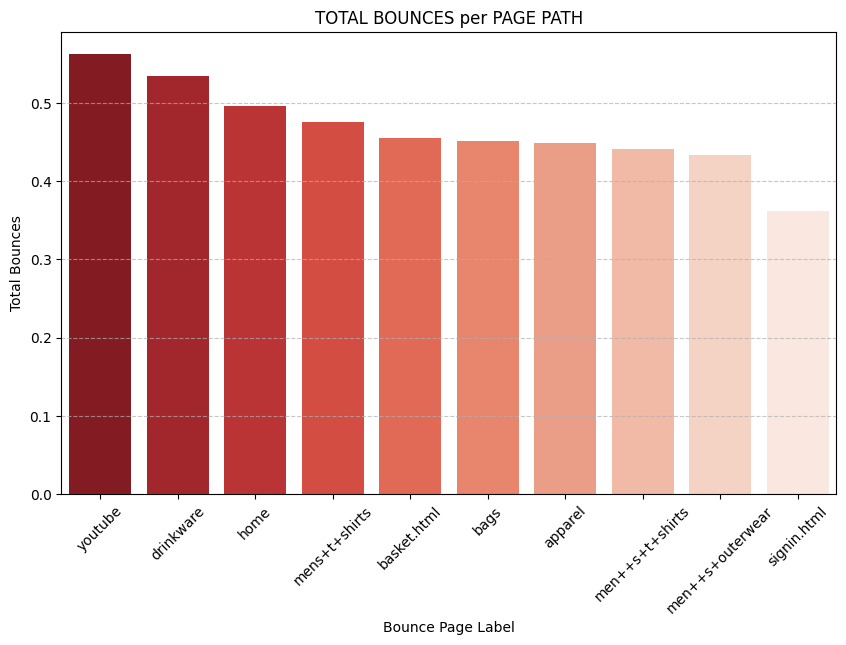

In [109]:
# 시각화
bounce_result_df = bounce_result_df.sort_values("bounce_rate", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=bounce_result_df['label'], y=bounce_result_df['bounce_rate'], palette='Reds_r')
plt.xlabel("Bounce Page Label")
plt.ylabel("Total Bounces")
plt.title("TOTAL BOUNCES per PAGE PATH")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

랜딩페이지가 'home'일 때의 이탈수가 앞도적으로 가장 높지만, 비율로 봤을 때 이탈률이 가장 높은 페이지는 youtube(유튜브 브랜드 상품)이다.

그 뒤로 drinkware(컵), mens t shirt이 뒤따르고 있고 basket.html과 같이 장바구니 화면에서 이탈한 경우가 꽤 높은 비율을 차지하고 있다는 것을 알 수 있다.

signin.html과 같이 로그인 페이지에서 이탈한 경우도 확인할 수 있다.

### (2) 종료율(exit rate) 분석
- 종료율 = 종료수(total.bounces) / 방문수(views)
- 이탈률과 다르게 종료율은 사용자가 여러 페이지를 이동하다가 마지막으로 세션을 종료시킨 페이지를 통해 분석한다.

In [108]:
exit_df = sample_df.copy()

# 딕셔너리에서 필요한 값 추출
def get_page_path(x):
    if isinstance(x, dict) and x.get("type") == "PAGE":  # hitNumber 조건 제외
        page = x.get("page")  # "page" 키가 있는지 확인
        if isinstance(page, dict) and "pagePath" in page:  # "page"가 딕셔너리이고 "pagePath"가 존재하는지 확인
            return page["pagePath"]  # "pagePath" 값 반환
    return None  # 조건에 맞지 않으면 None 반환

exit_df["page_path"] = exit_df["hits"].apply(get_page_path)
exit_df["totals.bounces"] = exit_df["totals.bounces"].astype(float)

# NaN 필터링
df_filtered = exit_df[exit_df["page_path"].notna()][["page_path", "totals.bounces"]]

# GROUP BY (페이지별 방문 수 & 이탈률 계산)
exit_result_df = df_filtered.groupby("page_path").agg(
    views=("page_path", "count"),               # 총 방문 횟수
    total_exits=("totals.bounces", "sum")       # 총 종료 횟수
).reset_index()

# 이탈률 계산
exit_result_df["exit_rate"] = exit_result_df["total_exits"] / exit_result_df["views"]

# page_path label 지정
exit_result_df['label'] = exit_result_df['page_path'].apply(lambda x : x.split('/')[-1])

# 정렬 및 상위 10개 출력
exit_result_df = exit_result_df.sort_values("views", ascending=False).head(10)

exit_result_df

,page_path,views,total_exits,exit_rate,label
1181,/home,616005,304062.0,0.493603,home
1158,/google+redesign/shop+by+brand/youtube,81528,45843.0,0.562298,youtube
265,/google+redesign/apparel/men++s/men++s+t+shirts,20709,9134.0,0.441064,men++s+t+shirts
1218,/signin.html,16326,5908.0,0.361877,signin.html
514,/google+redesign/apparel/mens/mens+t+shirts,12702,6035.0,0.475122,mens+t+shirts
3,/basket.html,9476,4296.0,0.453356,basket.html
764,/google+redesign/drinkware,8855,4720.0,0.533032,drinkware
644,/google+redesign/bags,8633,3890.0,0.450597,bags
142,/google+redesign/apparel,6366,2843.0,0.446591,apparel
261,/google+redesign/apparel/men++s/men++s+outerwear,6357,2750.0,0.432594,men++s+outerwear


/var/folders/l3/cq8y8n3s03v315zt58m2zrv80000gn/T/ipykernel_35823/288519863.py:5: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




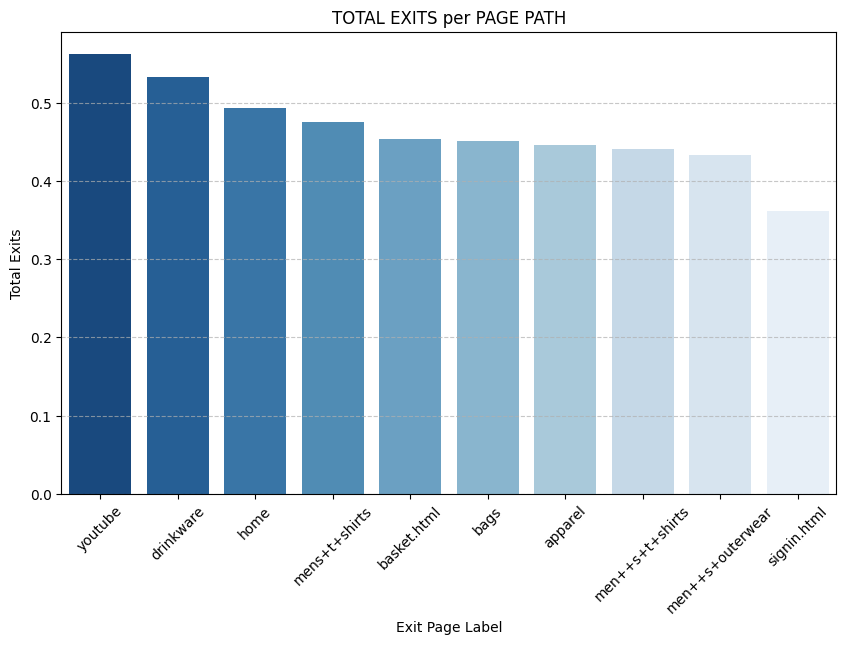

In [110]:
# 시각화
exit_result_df = exit_result_df.sort_values("exit_rate", ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=exit_result_df['label'], y=exit_result_df['exit_rate'], palette='Blues_r')
plt.xlabel("Exit Page Label")
plt.ylabel("Total Exits")
plt.title("TOTAL EXITS per PAGE PATH")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

### 종료율과 이탈율 인사이트
종료율과 이탈율이 상당히 비슷한 양상을 띄고 있다.

방문자 수는 기본 홈페이지(home)이 압도적으로 많지만, 이탈과 종료 비율로 확인했을 때 대부분 유튜브 브랜드 상품(/youtube)에서 종료 및 이탈을 하며, drinkware, home에서의 종료 및 이탈율이 뒤를 따르고 있다.

또한 signin.html, basket.html이 top10 순위에 속해 있다는 것은 재방문 고객이 많다는 것을 알 수 있다.

## 2. 브라우저 및 기기별 분석
- 세션별 접속한 브라우저와 기기 정보에 따른 종료율 분석
- 브라우저 및 기기의 호환성 문제 파악